# <span style="font-width:bold; font-size: 3rem; color:#1EB182;"> **Air Quality** </span><span style="font-width:bold; font-size: 3rem; color:#333;">- Part 04: Batch Inference</span>

## 🗒️ This notebook is divided into the following sections:

1. Download model and batch inference data
2. Make predictions, generate PNG for forecast
3. Store predictions in a monitoring feature group adn generate PNG for hindcast

## <span style='color:#ff5f27'> 📝 Imports

In [1]:
import sys
from pathlib import Path
import os

def is_google_colab() -> bool:
    if "google.colab" in str(get_ipython()):
        return True
    return False

def clone_repository() -> None:
    !git clone https://github.com/featurestorebook/mlfs-book.git
    %cd mlfs-book

def install_dependencies() -> None:
    !pip install --upgrade uv
    !uv pip install --all-extras --system --requirement pyproject.toml


if is_google_colab():
    clone_repository()
    install_dependencies()
    root_dir = str(Path().absolute())
    print("Google Colab environment")
else:
    root_dir = Path().absolute()
    # Strip ~/notebooks/ccfraud from PYTHON_PATH if notebook started in one of these subdirectories
    if root_dir.parts[-1:] == ('airquality',):
        root_dir = Path(*root_dir.parts[:-1])
    if root_dir.parts[-1:] == ('notebooks',):
        root_dir = Path(*root_dir.parts[:-1])
    root_dir = str(root_dir) 
    print("Local environment")

# Add the root directory to the `PYTHONPATH` to use the `recsys` Python module from the notebook.
if root_dir not in sys.path:
    sys.path.append(root_dir)
print(f"Added the following directory to the PYTHONPATH: {root_dir}")
    
# Read the API keys and configuration variables from the file <root_dir>/.env
from mlfs import config
if os.path.exists(f"{root_dir}/.env"):
    settings = config.HopsworksSettings(_env_file=f"{root_dir}/.env")

Local environment
Added the following directory to the PYTHONPATH: /Users/zhangman/Documents/25_p2/scalable/lab/mlfs-book
HopsworksSettings initialized!


In [2]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from mlfs.airquality import util

In [3]:
today = datetime.datetime.now() - datetime.timedelta(0)
tomorrow = today + datetime.timedelta(days = 1)
today

datetime.datetime(2025, 11, 18, 10, 36, 8, 867413)

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [6]:
project = hopsworks.login()
fs = project.get_feature_store() 

secrets = hopsworks.get_secrets_api()
all_locations = json.loads(secrets.get_secret("SENSOR_LOCATION_JSON").value)
location=all_locations["sensor1"]
country=location['country']
city=location['city']
street=location['street']

2025-11-18 10:36:45,518 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-11-18 10:36:45,526 INFO: Initializing external client
2025-11-18 10:36:45,527 INFO: Base URL: https://c.app.hopsworks.ai:443


2025-11-18 10:36:47,009 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1296532


## <span style="color:#ff5f27;">🪝 Download the model from Model Registry</span>

In [7]:
mr = project.get_model_registry()

retrieved_model = mr.get_model(
    name="air_quality_xgboost_model",
    version=1,
)

fv = retrieved_model.get_feature_view()

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()

2025-11-18 10:36:59,691 INFO: There is no parent information


Downloading: 0.000%|          | 0/553387 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/90999 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/17123 elapsed<00:00 remaining<?

In [8]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
retrieved_xgboost_model = XGBRegressor()

retrieved_xgboost_model.load_model(saved_model_dir + "/model.json")

# Displaying the retrieved XGBoost regressor model
retrieved_xgboost_model

XGBRegressor(base_score='5.72269E1', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float'], gamma=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## <span style="color:#ff5f27;">✨ Get Weather Forecast Features with Feature View   </span>



In [9]:
weather_fg = fs.get_feature_group(
    name='weather',
    version=1,
)
batch_data = weather_fg.filter(weather_fg.date >= today).read()
batch_data

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.72s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city
0,2025-11-19 00:00:00+00:00,4.1,0.0,18.079027,324.727478,london
1,2025-11-20 00:00:00+00:00,4.5,0.0,17.651016,348.231720,london
2,2025-11-19 00:00:00+00:00,5.3,0.2,16.870138,309.805511,londonboroughofwandsworth
3,2025-11-20 00:00:00+00:00,5.4,0.0,17.026896,346.551361,londonboroughofwandsworth


### <span style="color:#ff5f27;">🤖 Making the predictions</span>

In [10]:
batch_data['predicted_pm25'] = retrieved_xgboost_model.predict(
    batch_data[['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']])
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25
0,2025-11-19 00:00:00+00:00,4.1,0.0,18.079027,324.727478,london,59.881123
1,2025-11-20 00:00:00+00:00,4.5,0.0,17.651016,348.231720,london,53.342930
2,2025-11-19 00:00:00+00:00,5.3,0.2,16.870138,309.805511,londonboroughofwandsworth,56.112370
3,2025-11-20 00:00:00+00:00,5.4,0.0,17.026896,346.551361,londonboroughofwandsworth,59.701355


In [11]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 7 columns):
 #   Column                       Non-Null Count  Dtype                  
---  ------                       --------------  -----                  
 0   date                         4 non-null      datetime64[us, Etc/UTC]
 1   temperature_2m_mean          4 non-null      float32                
 2   precipitation_sum            4 non-null      float32                
 3   wind_speed_10m_max           4 non-null      float32                
 4   wind_direction_10m_dominant  4 non-null      float32                
 5   city                         4 non-null      object                 
 6   predicted_pm25               4 non-null      float32                
dtypes: datetime64[us, Etc/UTC](1), float32(5), object(1)
memory usage: 272.0+ bytes


### <span style="color:#ff5f27;">🤖 Saving the predictions (for monitoring) to a Feature Group</span>

In [12]:
batch_data['street'] = street
batch_data['city'] = city
batch_data['country'] = country
# Fill in the number of days before the date on which you made the forecast (base_date)
batch_data['days_before_forecast_day'] = range(1, len(batch_data)+1)
batch_data = batch_data.sort_values(by=['date'])
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25,street,country,days_before_forecast_day
0,2025-11-19 00:00:00+00:00,4.1,0.0,18.079027,324.727478,london,59.881123,london,unitedkingdom,1
2,2025-11-19 00:00:00+00:00,5.3,0.2,16.870138,309.805511,london,56.112370,london,unitedkingdom,3
1,2025-11-20 00:00:00+00:00,4.5,0.0,17.651016,348.231720,london,53.342930,london,unitedkingdom,2
3,2025-11-20 00:00:00+00:00,5.4,0.0,17.026896,346.551361,london,59.701355,london,unitedkingdom,4


In [13]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4 entries, 0 to 3
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype                  
---  ------                       --------------  -----                  
 0   date                         4 non-null      datetime64[us, Etc/UTC]
 1   temperature_2m_mean          4 non-null      float32                
 2   precipitation_sum            4 non-null      float32                
 3   wind_speed_10m_max           4 non-null      float32                
 4   wind_direction_10m_dominant  4 non-null      float32                
 5   city                         4 non-null      object                 
 6   predicted_pm25               4 non-null      float32                
 7   street                       4 non-null      object                 
 8   country                      4 non-null      object                 
 9   days_before_forecast_day     4 non-null      int64                  
dtypes: datetime

### Create Forecast Graph
Draw a graph of the predictions with dates as a PNG and save it to the github repo
Show it on github pages

2025-11-18 10:37:18,741 WARNING: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.



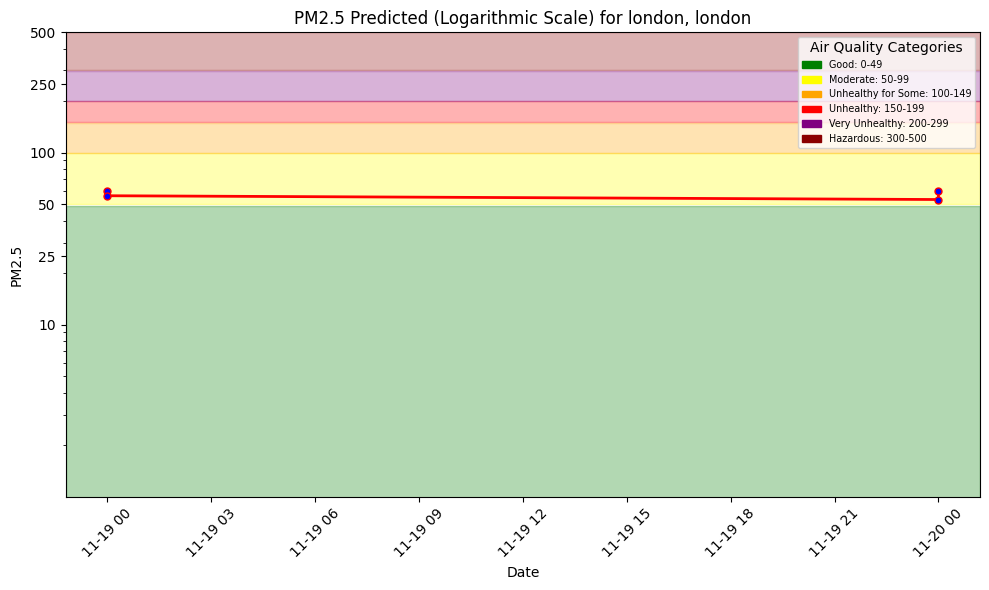

In [14]:

pred_file_path = f"{root_dir}/docs/air-quality/assets/img/pm25_forecast.png"
plt = util.plot_air_quality_forecast(city, street, batch_data, pred_file_path)

plt.show()

In [15]:
# Get or create feature group
monitor_fg = fs.get_or_create_feature_group(
    name='aq_predictions',
    description='Air Quality prediction monitoring',
    version=1,
    primary_key=['city','street','date','days_before_forecast_day'],
    event_time="date"
)

In [16]:
monitor_fg.insert(batch_data, wait=True)

Uploading Dataframe: 100.00% |█████████████████| Rows 4/4 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: aq_predictions_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1296532/jobs/named/aq_predictions_1_offline_fg_materialization/executions
2025-11-18 10:38:14,019 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-18 10:38:20,434 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-18 10:40:13,192 INFO: Waiting for execution to finish. Current state: SUCCEEDING. Final status: UNDEFINED
2025-11-18 10:40:26,073 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-18 10:40:26,250 INFO: Waiting for log aggregation to finish.
2025-11-18 10:40:51,820 INFO: Execution finished successfully.


(Job('aq_predictions_1_offline_fg_materialization', 'SPARK'), None)

In [17]:
# We will create a hindcast chart for  only the forecasts made 1 day beforehand
monitoring_df = monitor_fg.filter(monitor_fg.days_before_forecast_day == 1).read()
monitoring_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.11s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25,street,country,days_before_forecast_day
0,2025-11-15 00:00:00+00:00,10.75,0.0,14.618837,52.001225,london,75.937759,london,unitedkingdom,1
1,2025-11-19 00:00:00+00:00,4.10,0.0,18.079027,324.727478,london,59.881123,london,unitedkingdom,1


In [18]:
air_quality_fg = fs.get_feature_group(name='air_quality', version=1)
air_quality_df = air_quality_fg.read()
air_quality_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.20s) 


,date,pm25,pm25_lag1,pm25_lag2,pm25_lag3,pm25_lagged,country,city,street,url
0,2014-09-20 00:00:00+00:00,97.00,118.000000,130.00,126.00,115.000000,unitedkingdom,london,london,https://api.waqi.info/feed/@5724
1,2022-05-22 00:00:00+00:00,50.00,50.000000,44.00,42.00,48.000000,unitedkingdom,london,london,https://api.waqi.info/feed/@5724
2,2015-01-07 00:00:00+00:00,53.00,51.000000,72.00,88.00,58.666668,unitedkingdom,london,london,https://api.waqi.info/feed/@5724
3,2019-11-22 00:00:00+00:00,43.00,68.000000,63.00,72.00,58.000000,unitedkingdom,london,london,https://api.waqi.info/feed/@5724
4,2023-02-22 00:00:00+00:00,67.00,50.000000,38.00,45.00,51.666668,unitedkingdom,london,london,https://api.waqi.info/feed/@5724
...,...,...,...,...,...,...,...,...,...,...
4948,2025-07-08 00:00:00+00:00,2.94,4.380000,3.52,3.31,3.613333,unitedkingdom,londonboroughofwandsworth,batterseaparkroad,https://api.waqi.info/feed/A516559/
4949,2025-08-31 00:00:00+00:00,2.17,1.820000,2.72,1.59,2.236667,unitedkingdom,londonboroughofwandsworth,batterseaparkroad,https://api.waqi.info/feed/A516559/
4950,2025-08-26 00:00:00+00:00,3.35,4.000000,3.46,4.93,3.603333,unitedkingdom,londonboroughofwandsworth,batterseaparkroad,https://api.waqi.info/feed/A516559/
4951,2025-01-16 00:00:00+00:00,22.91,24.639999,20.35,12.32,22.633333,unitedkingdom,londonboroughofwandsworth,batterseaparkroad,https://api.waqi.info/feed/A516559/


In [19]:
outcome_df = air_quality_df[['date', 'pm25']]
preds_df =  monitoring_df[['date', 'predicted_pm25']]

hindcast_df = pd.merge(preds_df, outcome_df, on="date")
hindcast_df = hindcast_df.sort_values(by=['date'])

# If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
if len(hindcast_df) == 0:
    hindcast_df = util.backfill_predictions_for_monitoring(weather_fg, air_quality_df, monitor_fg, retrieved_xgboost_model)
hindcast_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.82s) 


Uploading Dataframe: 0.00% |                       | Rows 0/0 | Elapsed Time: 00:00 | Remaining Time: ?


Launching job: aq_predictions_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1296532/jobs/named/aq_predictions_1_offline_fg_materialization/executions
2025-11-18 10:41:16,594 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-18 10:41:19,802 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-18 10:42:20,776 INFO: Waiting for execution to finish. Current state: SUCCEEDING. Final status: UNDEFINED
2025-11-18 10:42:27,193 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-18 10:42:27,366 INFO: Waiting for log aggregation to finish.
2025-11-18 10:42:42,688 INFO: Execution finished successfully.


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25,pm25,street,country,days_before_forecast_day


### Plot the Hindcast comparing predicted with forecasted values (1-day prior forecast)

__This graph will be empty to begin with - this is normal.__

After a few days of predictions and observations, you will get data points in this graph.

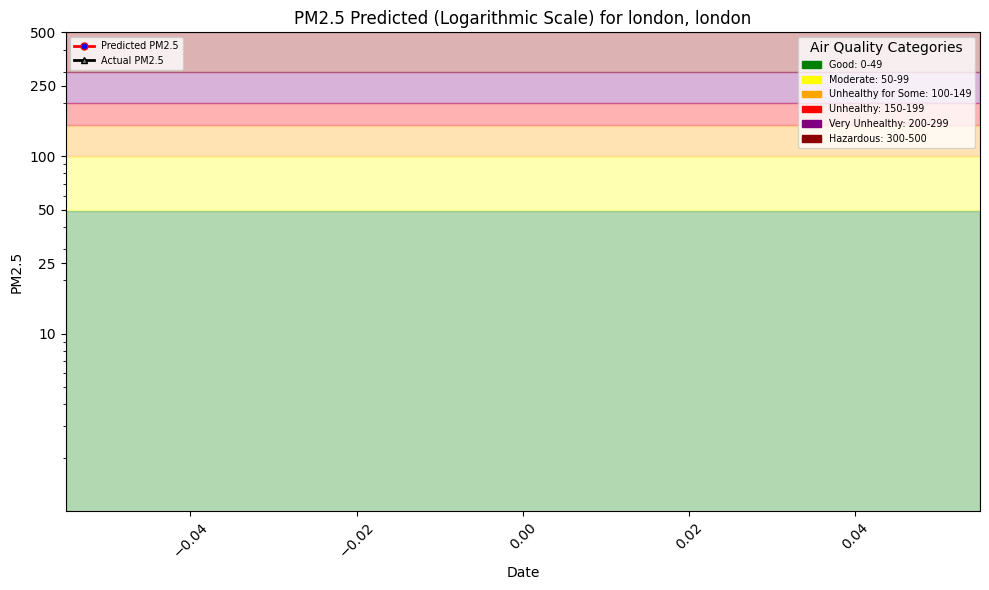

In [20]:
hindcast_file_path = f"{root_dir}/docs/air-quality/assets/img/pm25_hindcast_1day.png"
plt = util.plot_air_quality_forecast(city, street, hindcast_df, hindcast_file_path, hindcast=True)
plt.show()

### Upload the prediction and hindcast dashboards (png files) to Hopsworks


In [ ]:
dataset_api = project.get_dataset_api()
str_today = today.strftime("%Y-%m-%d")
if dataset_api.exists("Resources/airquality") == False:
    dataset_api.mkdir("Resources/airquality")
dataset_api.upload(pred_file_path, f"Resources/airquality/{city}_{street}_{str_today}", overwrite=True)
dataset_api.upload(hindcast_file_path, f"Resources/airquality/{city}_{street}_{str_today}", overwrite=True)

proj_url = project.get_url()
print(f"See images in Hopsworks here: {proj_url}/settings/fb/path/Resources/airquality")

Uploading /Users/zhangman/Documents/25_p2/scalable/lab/mlfs-book/docs/air-quality/assets/img/pm25_forecast.png…

Uploading /Users/zhangman/Documents/25_p2/scalable/lab/mlfs-book/docs/air-quality/assets/img/pm25_hindcast_1da…

---